In [1]:
import cv2
import numpy  as np 
import pandas as pd
import matplotlib.pylab as plt

In [2]:
def view(img, x=7, y=7, _cmap='autumn_r'):
    plt.figure(figsize=(x, y))
    plt.imshow(img, cmap=_cmap)
    plt.show()

### Const

In [3]:
min_crossing_angle = 1

### Functions

In [4]:
def region_of_interest_rgb(img, vertices):
    mask             = np.zeros_like(img)
    channel_count    = img.shape[2]
    match_mask_color = (255,) * channel_count # (255, 255, 255)
    
    cv2.fillPoly(mask, vertices, match_mask_color)
   
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def region_of_interest_canny(img, vertices):
    mask             = np.zeros_like(img)
    match_mask_color = 255
    
    cv2.fillPoly(mask, vertices, match_mask_color)
   
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### 1. Read Image

In [5]:
image   = cv2.imread('Rog49.png')
image   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

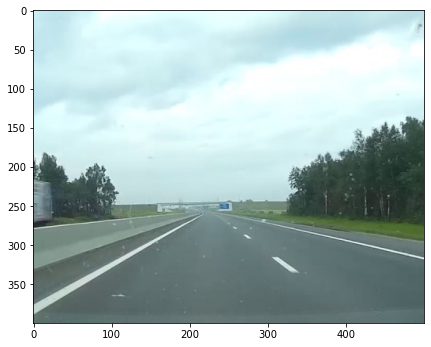

In [6]:
view(image)

### Function of interest region

In [7]:
h, w, _ = image.shape

region_of_VP = [
    (0, h),
    (w/2, h/2),
    (w, h)
]

cut_image = region_of_interest_rgb(image, 
                np.array([region_of_VP], np.int32))

### Make gray

In [8]:
gray      = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_cut  = cv2.cvtColor(cut_image, cv2.COLOR_RGB2GRAY)

### Make bloor

In [9]:
blur     = cv2.blur(gray,(3,3))
blur_cut = cv2.blur(gray_cut,(3,3))

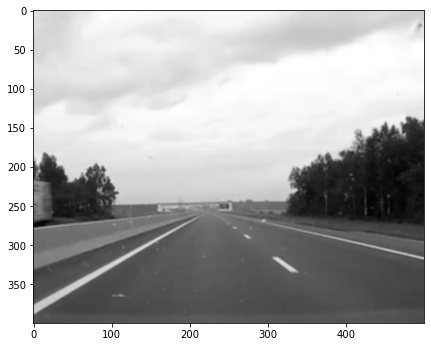

In [10]:
view(blur, _cmap='gray')

### Calcualte Median

In [11]:
medin = np.median(blur.reshape(-1)) # we calculate this to calculate low and high thresh
medin

213.0

### Calculate thresh

In [12]:
std_dev = 0.5

low_thresh  = medin / std_dev
high_thresh = medin * std_dev

print(low_thresh, "|||", high_thresh)

426.0 ||| 106.5


### Calculate Canny 

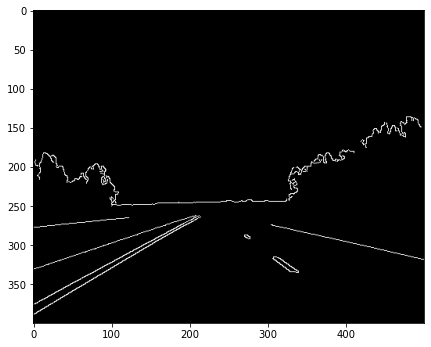

In [13]:
canny = cv2.Canny(blur, low_thresh, high_thresh)
view(canny, _cmap='gray')

### Hough threshold

In [14]:
def calculate_hough_threshold(img, houghlines_divisor):
    image_rows = img.shape[0] ** 2
    image_cols = img.shape[1] ** 2
    
    hough_threshold = (np.sqrt(image_rows + image_cols) / houghlines_divisor)
    
    return hough_threshold

In [15]:
houghlines_divisor = 19
hough_threshold    = int(calculate_hough_threshold(canny, houghlines_divisor))
hough_threshold

33

### Hough 

In [16]:
lines  = cv2.HoughLines(canny, 1, np.pi / 180, hough_threshold)
points = []

In [17]:
def draw_hough_lines(img, lines):
        
    copy_img = img.copy()
    img2 = img.copy()
    
    for i in range(len(lines)):
        # rho Это дистанция до кординаты (center,center)
        # theta угол повората изображения
        rho    = lines[i][0][0]
        theta1 = lines[i][0][1]
        
        theta_thresh  = 0.2
        
        costheta1 = 0
        costheta2 = 0
        
        sintheta1 = 0
        sintheta2 = 0 
        
        rho1 = 0
        rho2 = 0
        
        if ((theta1 >(0 + theta_thresh)) and (theta1 < (np.pi / 2 - theta_thresh)) or (theta1 >((np.pi / 2) + theta_thresh)) and (theta1 < (np.pi - theta_thresh))):
            
            # a нормирование 
            # b нормирование
            a = np.cos(theta1)
            b = np.sin(theta1)
            # кадинаты
            x0 = a * rho
            y0 = b * rho
            
            # начало вектора
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            # конец вектора
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            # Рисование 
            cv2.line(copy_img, (x1, y1), (x2, y2), (0, 255, 255), 2)
            
            costheta1 = np.cos(theta1)
            sintheta1 = np.sin(theta1)
            rho1 = rho
            
            for j in range(i + 1, len(lines)):
                rho    = lines[j][0][0]
                theta2 = lines[j][0][1]
                
                costheta2 = np.cos(theta2)
                sintheta2 = np.sin(theta2)
                
                rho2 = rho
                
                if ((np.abs(theta1) - np.abs(theta2)) < min_crossing_angle):
                    break
            
                determinative = (costheta1 * sintheta2) - (sintheta1 * costheta2)

                intersection_x = ( ( sintheta2 * rho1) - (sintheta1 * rho2) ) / determinative
                intersection_y = ( (-costheta2 * rho1) + (costheta1 * rho2) ) / determinative
                
                if (intersection_x > 0) and (intersection_y > 0):
                    if not np.isinf(intersection_x):
                        if not np.isinf(intersection_y):
                    
                            intersection_x = int(intersection_x)
                            intersection_y = int(intersection_y)
                            points.append([intersection_x, intersection_y])
                            img2 = cv2.drawMarker(img2, (intersection_x, intersection_y), (0, 255, 255), cv2.MARKER_CROSS, 5, 5, 1)
                
    return img2

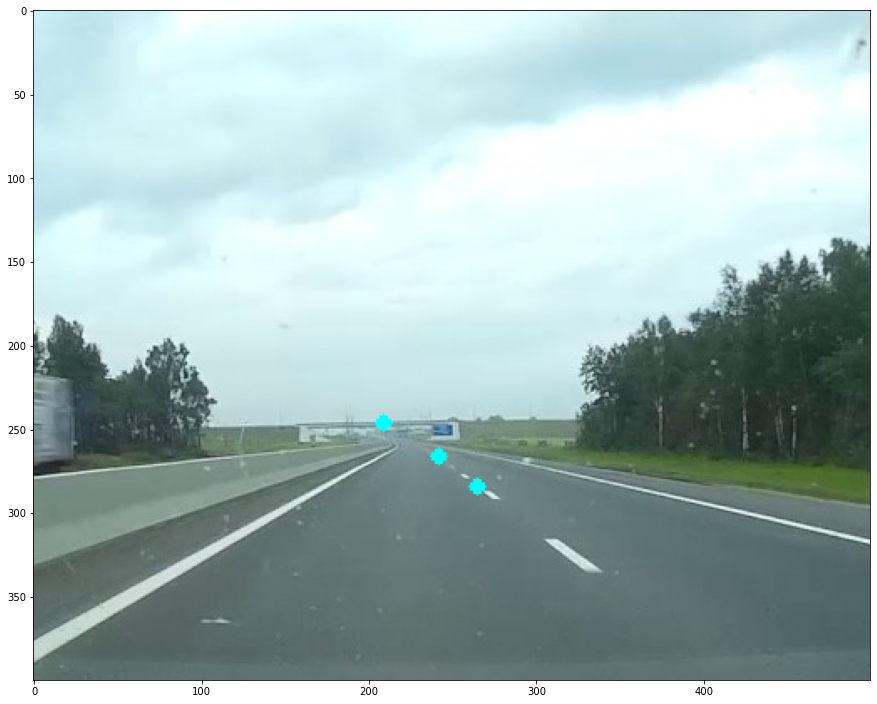

In [18]:
view(draw_hough_lines(image, lines), 15, 15)

### Kmeans

In [19]:
from sklearn import cluster

In [20]:
def cluster_intersects(points):
    db = cluster.DBSCAN(eps=5, min_samples=1).fit(np.array(points))
    labels = db.labels_
    biggest_cluster = np.argmax(np.bincount(labels))
    vp = tuple(np.mean(np.array(points)[labels==biggest_cluster], axis=0).astype('int'))
    return vp

In [21]:
def draw_vp_of_clustering(img, points):
    new_img = img.copy()
    vp = cluster_intersects(points)
    new_img = cv2.drawMarker(new_img, vp, (0, 255, 255), cv2.MARKER_CROSS, 5, 5, 1)
    print(vp)
    return new_img

(209, 246)


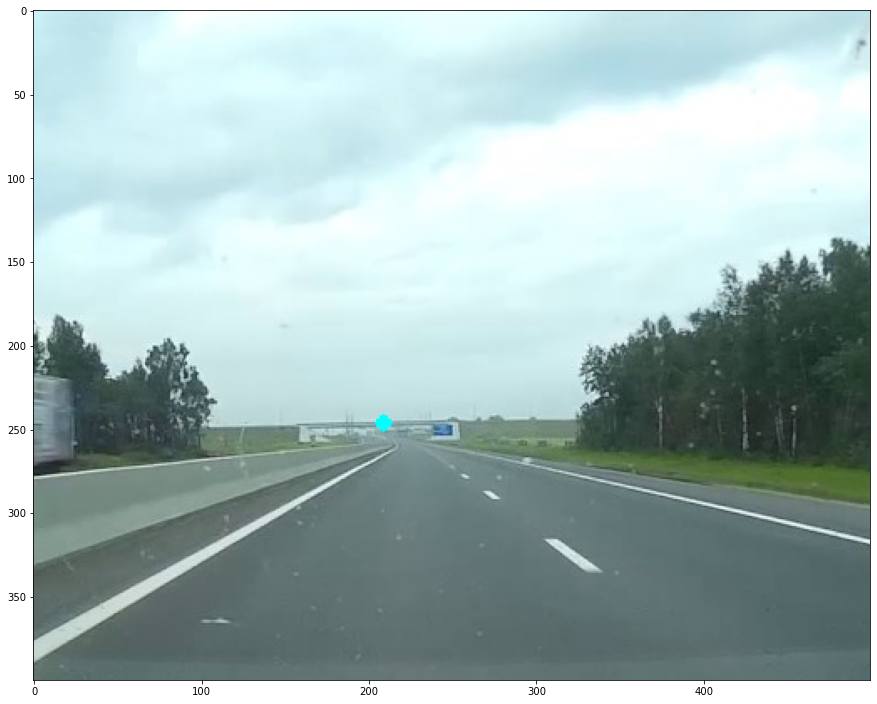

In [22]:
view(draw_vp_of_clustering(image, points), 15, 15)